In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
'''
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
'''
def scale(train,test):
    scaler=1000
    train_scaled =train/scaler
    test_scaled = test/scaler
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
'''
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
'''

def invert_scale(scaler,yhat):
    inverted = scaler *yhat
    return inverted

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


Using Theano backend.


In [2]:
f = open( 'score_result_shampoo_sales_original_original.txt', 'w' )
f.write('epoch|neuron|rmse \n' )
f.close()

In [ ]:
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)


# transform data to be supervised learning
#supervised = timeseries_to_supervised(diff_values, 1)
supervised = timeseries_to_supervised(raw_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

nb_epoch_range=range(100,1100,100)
neuron_range=[1]
for i1 in nb_epoch_range:
    for i2 in neuron_range:
        # repeat experiment
        repeats = 10
        error_scores = []
        for r in range(repeats):
            # fit the model
            lstm_model = fit_lstm(train_scaled, 1, i1, i2)
            # forecast the entire training dataset to build up state for forecasting
            train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
            lstm_model.predict(train_reshaped, batch_size=1)
            # walk-forward validation on the test data
            predictions = list()
            for i in range(len(test_scaled)):
                # make one-step forecast
                X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
                yhat = forecast_lstm(lstm_model, 1, X)
                ##used to check transform and inverted working correctly
                #yhat = y
                # invert scaling
                yhat = invert_scale(scaler, yhat)
                # invert differencing
                #yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
                # store forecast
                predictions.append(yhat)
                expected = raw_values[len(train) + i]
                #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
            # report performance
            rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
            #print('%d) Test RMSE: %.3f' % (r+1, rmse))
            error_scores.append([rmse])

            f = open( 'score_result_shampoo_sales_original_original.txt', 'a' )
            f.write(str(i1)+'|'+str(i2)+'|'+str(rmse)+'\n' )
            f.close()

print("done")
# summarize results
#results = DataFrame()
#results['rmse'] = error_scores
#mean=results.mean()
#print(results.describe())
#results.boxplot()
#pyplot.show()

In [2]:
import pandas as pd

#DataFrame.pivot_table(values=None, index=None, columns=None, aggfunc='mean',fill_value=None, margins=False, dropna=True)

df = pd.read_csv('score_result_shampoo_sales_original_original.txt',  sep='|')
df.pivot_table(index='epoch',columns='neuron',aggfunc=('count','mean'))

rmse             
       count        mean
neuron     1           1
epoch                   
100       10  267.234813
200       10  242.967515
300       10  206.108023
400       10  232.932652
500       10  247.138918
600       10  213.015129
700       10  238.240749
800       10  254.331621
900       10  297.916571
1000      10  291.333101

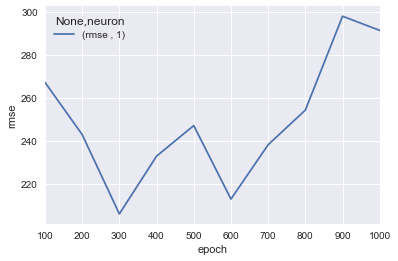

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # use seaborn styles

df.pivot_table(index='epoch',columns='neuron',aggfunc=('mean')).plot()
plt.ylabel('rmse');

### Conclusion:
- the increase in epoch doesn't lower the rmse